In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram

%matplotlib inline
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6352205.datarmor0/parcels-502027/libparcels_random_730f5452-c1be-46d6-94e9-7294ec2369b6.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    #w = cluster.scale(jobs=15)
    w = cluster.scale(jobs=2)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.240:33388 Dashboard: http://10.148.0.240:8787/status,Cluster Workers: 14 Cores: 14 Memory: 223.58 GiB


---
# compare Lagrangian and Eulerian spectra
### last update: 2023.08.14

In [4]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50/'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E = p.load_diagnostic('spectra_uv_T60_mean0_lon_lat.zarr').rename({'E':'E_Lagrangian'})
E_L = E.E_Lagrangian
E_L

<xarray.DataArray 'E_Lagrangian' (lon_bins: 359, lat_bins: 119, frequency: 1440)>
dask.array<open_dataset-c1f4f9d33c2841cdb153b0fd0e92724dE, shape=(359, 119, 1440), dtype=float64, chunksize=(359, 119, 100), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * lon_bins   (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5

In [5]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon.zarr')).rename({'E_SSUV': 'E_Eulerian'})
E_E = E_Eulerian
E_E

<xarray.Dataset>
Dimensions:     (frequency: 1440, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency   (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins    (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * lon_bins    (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E_Eulerian  (frequency, lon_bins, lat_bins) float64 dask.array<chunksize=(180, 45, 30), meta=np.ndarray>

In [6]:
ds = xr.merge([E_L, E_E])
ds.persist()

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins      (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * lon_bins      (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E_Lagrangian  (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(359, 119, 100), meta=np.ndarray>
    E_Eulerian    (frequency, lon_bins, lat_bins) float64 dask.array<chunksize=(180, 45, 30), meta=np.ndarray>

---
## Maps

Text(0.5, 0, '')

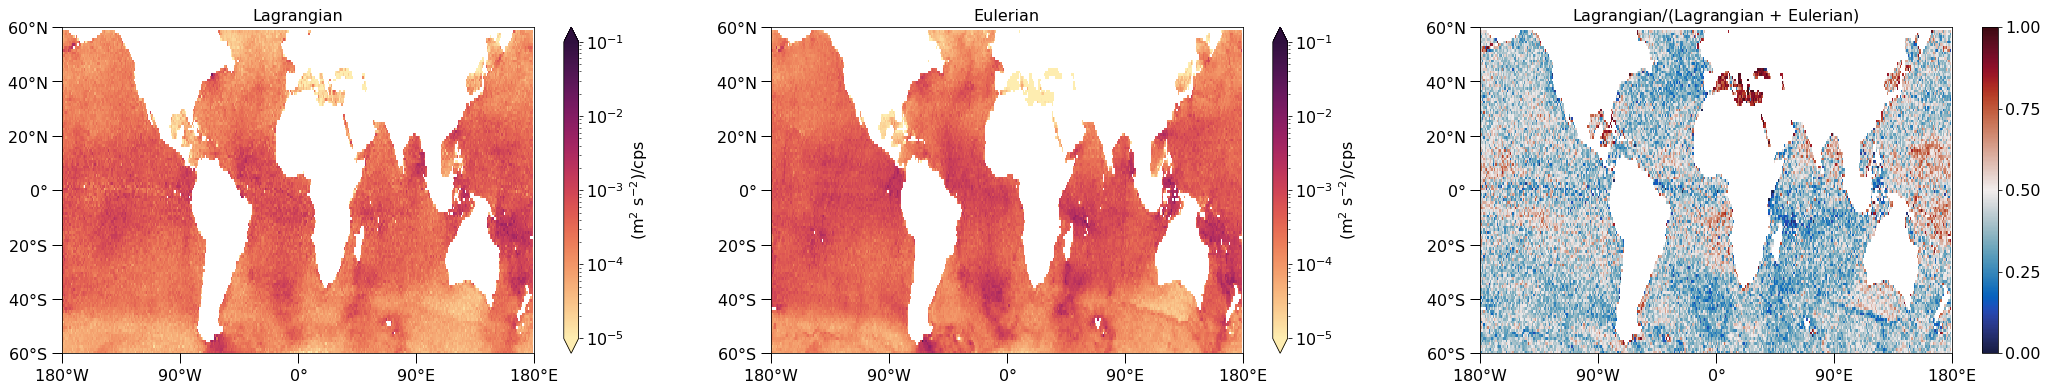

In [13]:
font_size = 16
freq_sel = 4

fig, ax = plt.subplots(figsize=(36,6))
ax = plt.subplot(131)
cax=(ds.E_Lagrangian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(132)
cax=(ds.E_Eulerian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(133)
cax = (ds.E_Lagrangian.sel(frequency=freq_sel)/(ds.E_Lagrangian.sel(frequency=freq_sel)+ds.E_Eulerian.sel(frequency=freq_sel))).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=1, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical', ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian/(Lagrangian $+$ Eulerian)' ,fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)



Text(0.5, 0, '')

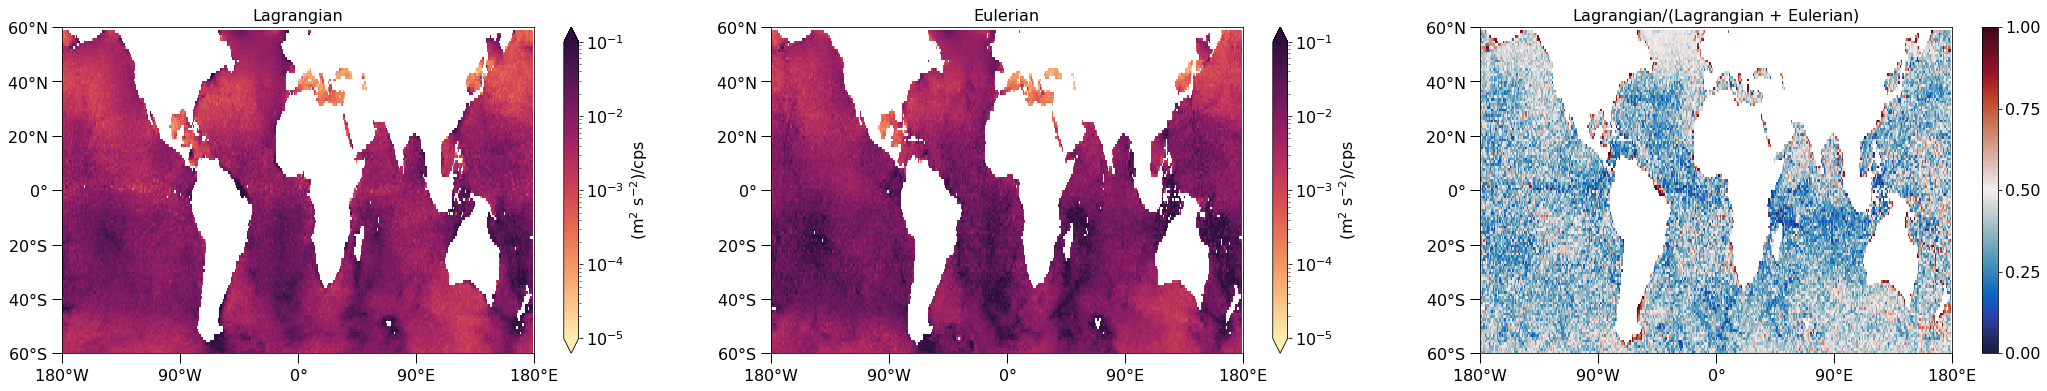

In [15]:
font_size = 16
freq_sel = 2

fig, ax = plt.subplots(figsize=(36,6))
ax = plt.subplot(131)
cax=(ds.E_Lagrangian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(132)
cax=(ds.E_Eulerian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(133)
cax = (ds.E_Lagrangian.sel(frequency=freq_sel)/(ds.E_Lagrangian.sel(frequency=freq_sel)+ds.E_Eulerian.sel(frequency=freq_sel))).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=1, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical', ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian/(Lagrangian $+$ Eulerian)' ,fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)



Text(0.5, 0, '')

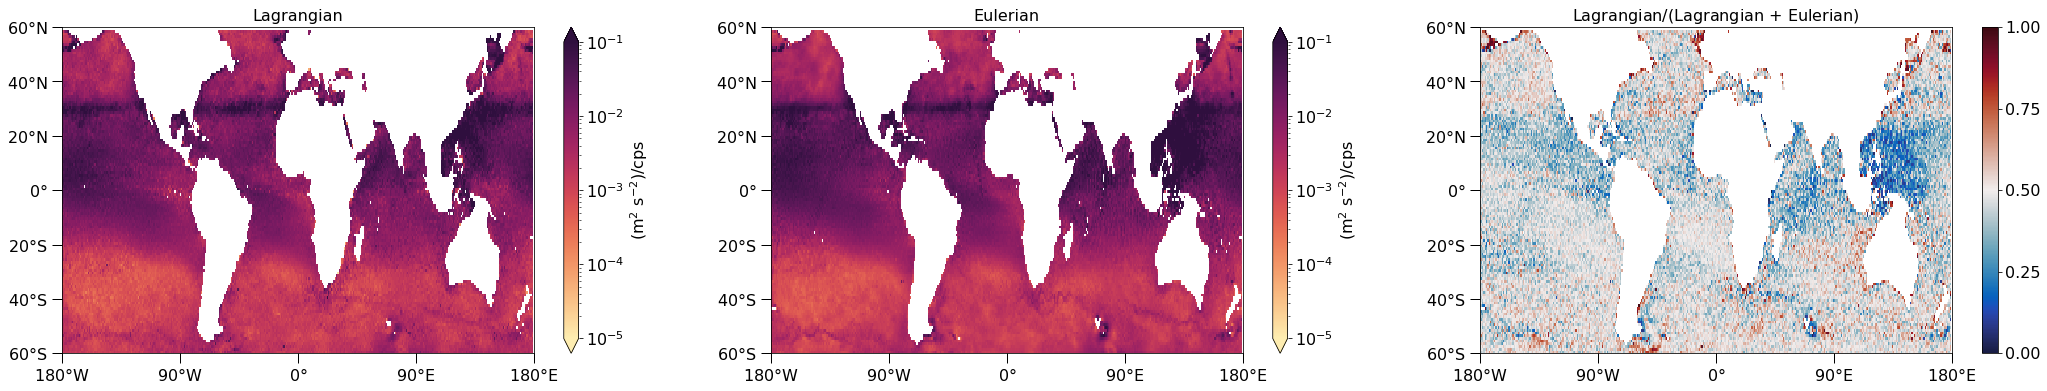

In [17]:
font_size = 16
freq_sel = -1

fig, ax = plt.subplots(figsize=(36,6))
ax = plt.subplot(131)
cax=(ds.E_Lagrangian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(132)
cax=(ds.E_Eulerian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(133)
cax = (ds.E_Lagrangian.sel(frequency=freq_sel)/(ds.E_Lagrangian.sel(frequency=freq_sel)+ds.E_Eulerian.sel(frequency=freq_sel))).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=1, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical', ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian/(Lagrangian $+$ Eulerian)' ,fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)



Text(0.5, 0, '')

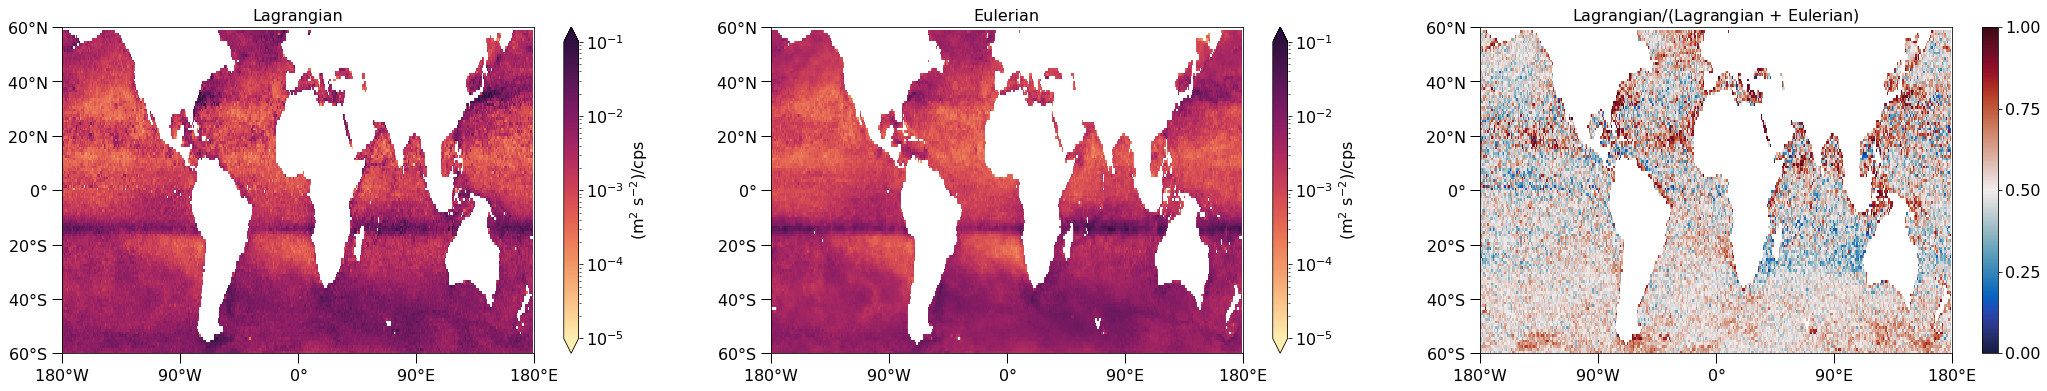

In [18]:
font_size = 16
freq_sel = 0.5

fig, ax = plt.subplots(figsize=(36,6))
ax = plt.subplot(131)
cax=(ds.E_Lagrangian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(132)
cax=(ds.E_Eulerian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(133)
cax = (ds.E_Lagrangian.sel(frequency=freq_sel)/(ds.E_Lagrangian.sel(frequency=freq_sel)+ds.E_Eulerian.sel(frequency=freq_sel))).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=1, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical', ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian/(Lagrangian $+$ Eulerian)' ,fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)



Text(0.5, 0, '')

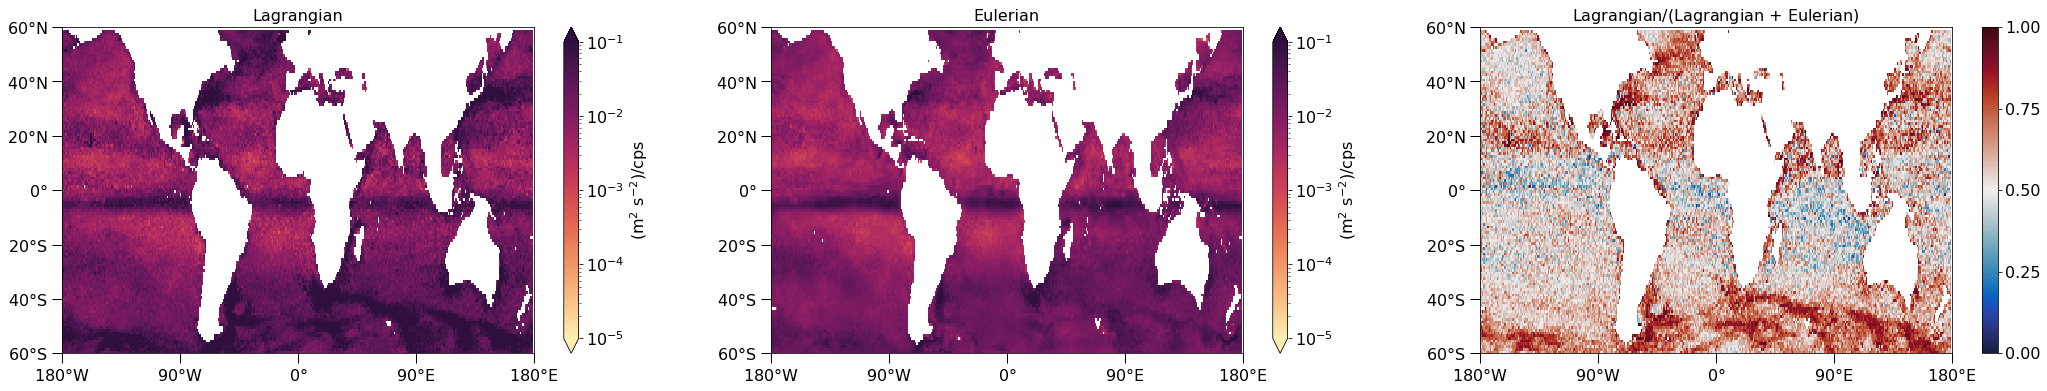

In [19]:
font_size = 16
freq_sel = 0.2

fig, ax = plt.subplots(figsize=(36,6))
ax = plt.subplot(131)
cax=(ds.E_Lagrangian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(132)
cax=(ds.E_Eulerian.sel(frequency=freq_sel)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)/cps', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(133)
cax = (ds.E_Lagrangian.sel(frequency=freq_sel)/(ds.E_Lagrangian.sel(frequency=freq_sel)+ds.E_Eulerian.sel(frequency=freq_sel))).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=1, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical', ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian/(Lagrangian $+$ Eulerian)' ,fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)



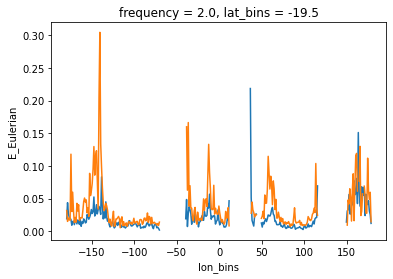

In [20]:
ds.E_Lagrangian.sel(frequency=2).isel(lat_bins=40).plot()
ds.E_Eulerian.sel(frequency=2).isel(lat_bins=40).plot()

In [22]:
cluster.close()